# 04 — Sentiment Analysis Modeling

## Objectives
- Menghasilkan label sentimen berbasis teks ulasan
- Membandingkan sentiment text vs rating numerik
- Mengidentifikasi disagreement (rating-text mismatch)
- Menyediakan fitur sentimen untuk analisis lanjutan

## Input
- data/processed/clean_e_wallet_reviews.csv

## Output
- Dataset dengan kolom sentiment_label & sentiment_score


GOOGLE DRIVE MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import pipeline

PATH CONFIGURATION & LOAD DATA

In [3]:
BASE_PATH = "/content/drive/MyDrive/ewallet_nlp_clustering_project"
PROCESSED_DATA_PATH = f"{BASE_PATH}/data/processed"
OUTPUT_PATH = f"{BASE_PATH}/outputs"

INPUT_FILE = f"{PROCESSED_DATA_PATH}/clean_e_wallet_reviews.csv"

df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df)} reviews")

Loaded 11141 reviews


## Sentiment Modeling Strategy

Model chosen:
- Transformer-based Indonesian sentiment model
- Advantages:
  - Context-aware
  - Robust to sarcasm & informal language
  - Outperforms lexicon-based approaches

Task:
- Text classification → {Negative, Neutral, Positive}

Inference mode:
- CPU or GPU (optional)

LOAD SENTIMENT MODEL

In [4]:
sentiment_pipeline = pipeline(
    task="sentiment-analysis",
    model="w11wo/indonesian-roberta-base-sentiment-classifier",
    device=0 if torch.cuda.is_available() else -1
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


SENTIMENT INFERENCE FUNCTION

In [5]:
def predict_sentiment(texts, batch_size=32):
    sentiments = []
    scores = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size].tolist()
        results = sentiment_pipeline(batch)

        for r in results:
            sentiments.append(r["label"])
            scores.append(r["score"])

    return sentiments, scores

RUN SENTIMENT ANALYSIS

In [6]:
sentiment_labels, sentiment_scores = predict_sentiment(df["clean_text"])

df["sentiment_label"] = sentiment_labels
df["sentiment_score"] = sentiment_scores

100%|██████████| 349/349 [20:46<00:00,  3.57s/it]


SENTIMENT DISTRIBUTION ANALYSIS

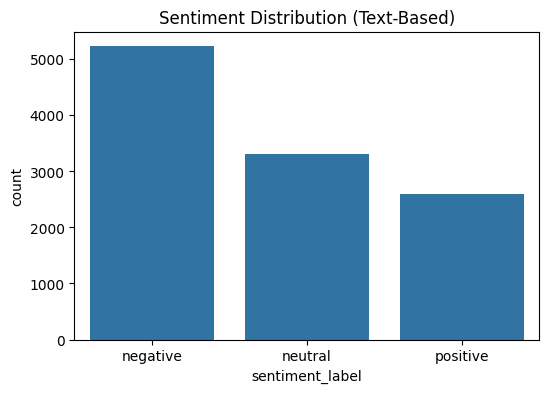

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment_label", data=df)
plt.title("Sentiment Distribution (Text-Based)")
plt.show()

SENTIMENT BY APPLICATION

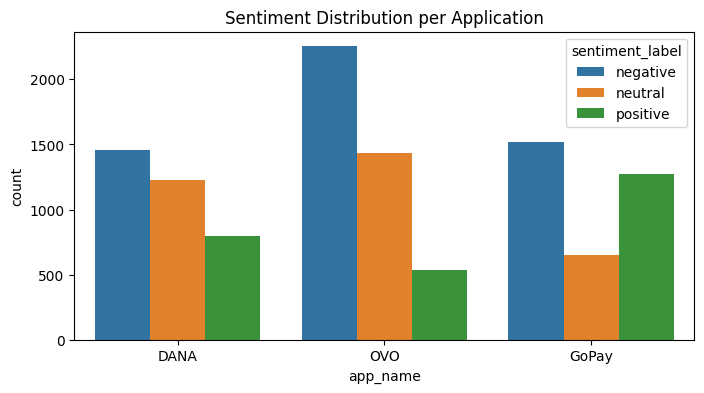

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="app_name", hue="sentiment_label")
plt.title("Sentiment Distribution per Application")
plt.show()

RATING-BASED SENTIMENT MAPPING

In [9]:
def rating_to_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

df["rating_sentiment"] = df["rating"].apply(rating_to_sentiment)

TEXT vs RATING DISAGREEMENT ANALYSIS

In [10]:
df["sentiment_mismatch"] = df["sentiment_label"] != df["rating_sentiment"]

mismatch_rate = df["sentiment_mismatch"].mean()
mismatch_rate

np.float64(1.0)

DISAGREEMENT VISUALIZATION

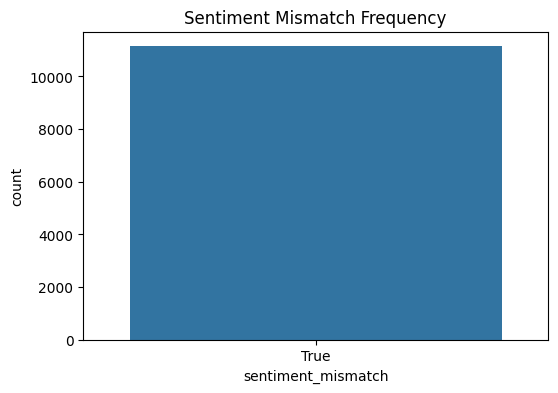

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment_mismatch", data=df)
plt.title("Sentiment Mismatch Frequency")
plt.show()

SENTIMENT CONFIDENCE ANALYSIS

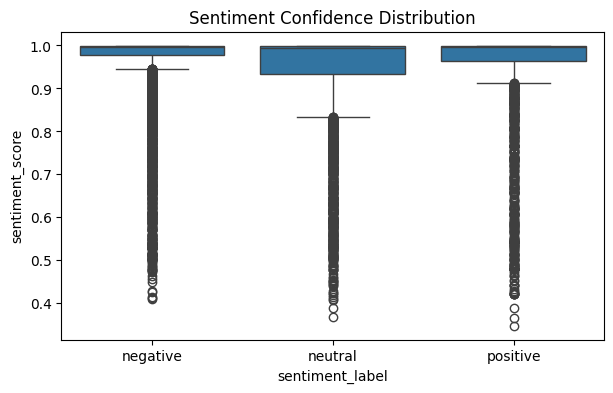

In [12]:
plt.figure(figsize=(7,4))
sns.boxplot(x="sentiment_label", y="sentiment_score", data=df)
plt.title("Sentiment Confidence Distribution")
plt.show()

SAVE DATASET WITH SENTIMENT FEATURES

In [13]:
OUTPUT_FILE = f"{PROCESSED_DATA_PATH}/sentiment_e_wallet_reviews.csv"

df.to_csv(OUTPUT_FILE, index=False)

print(f"Dataset saved with sentiment features:\n{OUTPUT_FILE}")

Dataset saved with sentiment features:
/content/drive/MyDrive/ewallet_nlp_clustering_project/data/processed/sentiment_e_wallet_reviews.csv


## Sentiment Analysis Summary

✔ Transformer-based sentiment classification applied  
✔ Context-aware text sentiment extracted  
✔ Rating vs text disagreement identified  
✔ Sentiment features prepared for clustering  

Conclusion:
Text-based sentiment provides richer emotional signal than rating alone,
supporting the need for emotion-aware user segmentation.
